# 从零实现线性回归

In [1]:
%matplotlib inline
import random
import torch
import numpy as np
import pandas as pd
from d2l import torch as d2l

## 1. 生成数据集

In [2]:
# 生成1000个样本，每个样本有2个正态分布的特征
# W = [2, -3.4], b = 4.2, 噪声~N（0, 0.01^2）

def synthetic_data(w, b, num_examples): #@save
    """生成 y = Wx + b + 噪声 """
    X = torch.normal(mean=0, std=1, size=(num_examples, len(w)))
    Y = torch.matmul(X, w) + b
    Y += torch.normal(mean=0, std=0.01, size=Y.shape)
    return X, Y.reshape((-1, 1))  # 注意最终返回的标签张量的维数，要返回一个二阶张量 N * 1

In [3]:
# torch.matmul(), torch.mv(), torch.mm() 对比

x = torch.ones((5, 3), dtype=torch.float32)
y1 = torch.tensor([1, 2, 3], dtype=torch.float32)
y2 = y1.reshape((-1, 1))

torch.matmul(x, y1), torch.matmul(x, y2), torch.mv(x, y1), torch.mm(x, y2)

(tensor([6., 6., 6., 6., 6.]),
 tensor([[6.],
         [6.],
         [6.],
         [6.],
         [6.]]),
 tensor([6., 6., 6., 6., 6.]),
 tensor([[6.],
         [6.],
         [6.],
         [6.],
         [6.]]))

In [4]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [5]:
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [6]:
features[0], labels[0]

(tensor([-0.9378,  1.8137]), tensor([-3.8372]))

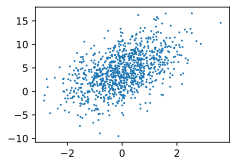

In [7]:
# 观测第一个特征和标签的散点图
d2l.set_figsize()
d2l.plt.scatter(features[:, 0].detach().numpy(), labels.detach().numpy(), 1)

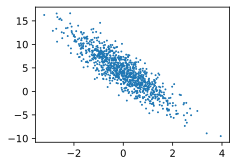

In [8]:
# 观测第二个特征和标签的散点图
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

# 2. 读取数据集

In [20]:
# 定义一个函数，用来生成小批量数据

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    
    random.shuffle(indices)
    
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [21]:
# 本段代码帮助理解上述返回值
a = torch.arange(12).reshape((6, 2))
b = torch.tensor([0, 2, 1, 4])
a, a[b], a[b, :]

(tensor([[ 0,  1],
         [ 2,  3],
         [ 4,  5],
         [ 6,  7],
         [ 8,  9],
         [10, 11]]),
 tensor([[0, 1],
         [4, 5],
         [2, 3],
         [8, 9]]),
 tensor([[0, 1],
         [4, 5],
         [2, 3],
         [8, 9]]))

In [22]:
# 本段代码帮助理解yield
# 把yield看作是return
# 带yield的函数是一个生成器，而不是一个函数了，这个生成器有一个函数就是next函数，next就相当于“下一步”生成哪个数
# 这一次的next开始的地方是接着上一次的next停止的地方执行的
# 所以调用next的时候，生成器并不会从test()函数的开始执行，只是接着上一步停止的地方开始，然后遇到yield后，return出要生成的数，此步就结束
def test():
    print("hello")
    for i in range(5):
        yield i
        
g = test()
next(g), next(g), next(g), next(g)

hello


(0, 1, 2, 3)

In [23]:
# 测试小批量数据的生成
batch_size = 10
for X, Y in data_iter(batch_size, features, labels):
    print(X, "\n", Y)
    break

tensor([[ 0.0101,  0.0236],
        [ 1.4599, -2.1496],
        [-0.3422,  1.2033],
        [ 0.6249,  0.0223],
        [ 0.4409,  0.7129],
        [ 0.4688, -1.0318],
        [-1.5853,  0.6693],
        [ 0.2548, -0.9199],
        [ 0.4170,  0.5033],
        [-0.0401, -2.2523]]) 
 tensor([[ 4.1342],
        [14.4351],
        [-0.5843],
        [ 5.3612],
        [ 2.6574],
        [ 8.6608],
        [-1.2242],
        [ 7.8276],
        [ 3.3315],
        [11.7732]])


至此，我们数据的读取工作已完成。

但需要注意的是，我们在这里写的这个读取数据的函数`data_iter()`仅仅是作为数据量小的时候的一个演示，这个函数、或者说这种读取数据的方法在实际中是不用的，关键原因在于其执行效率非常低，同时它需要将所有数据加载到内存中，并执行大量的随机内存访问。

在深度学习框架中，我们有内置的迭代器可以使用，效率要高得多

# 3. 初始化模型参数

In [47]:
# 对于 w ，我们通过从均值为0，标准差为0.01的正态分布中采样随机数来进行初始化
# 对于 b ， 我们将其初始化为 0

w = torch.normal(mean=0, std=0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# 4. 定义模型

In [25]:
def linreg(X, w, b): #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

# 5. 定义损失函数

In [32]:
# 注意我们将真实值的形状进行reshape，使其与预测值的形状一致，这里很关键

def squared_loss(y_pred, y_true): #@save
    """均方损失"""
    return 0.5 * (y_pred - y_true.reshape(y_pred.shape))**2

# 6. 定义优化算法

In [48]:
# 使用小批量随机梯度下降

def sgd(params, lr, batch_size): #@save
    """小批量随机梯度下降"""
    
    # 注意这里我们用torch.np_grad进行限制是因为我们更新参数的过程不应该被记入反向传播过程
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size  # 注意这里也是一个坑：不能写成 param = param - X，必须要写成 param -= X，这是引用的方式
            param.grad.zero_()

# 7. 训练

本部分提供了深度学习模型训练过程的模板：
1. 读取小批量样本
2. 通过模型获得一组预测值
3. 计算损失
4. 反向传播
5. 计算并存储每个参数的梯度
6. 调用优化算法来更新模型参数

在每个迭代周期（epoch）中，我们遍历**整个**数据集，并将训练数据集中所有样本都使用一次

In [42]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [49]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        
        # 注意l的形状是(batch_size, 1)，并非一个标量，因此在调用backward的时候需要注意：
        # 标量直接调用backward()，而向量要么用sum()转换成标量再调用backward，要么设置gradient参数，因此下面两个实现是等效的
        
        # l.sum().backward()
        l.backward(gradient=torch.ones(l.shape))
        
        sgd([w, b], lr, batch_size)
        
    # 注意这里要加上torch.no_grad()来限制不要计算梯度，我们仅仅是打印一下每个epoch的平均损失
    # 平均损失的计算过程不应该被加入backward反向传播中
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f"epoch {epoch+1}, loss {float(train_l.mean()):f}")

epoch 1, loss 0.028196
epoch 2, loss 0.000100
epoch 3, loss 0.000052


In [46]:
print(f"w 的估计误差：{true_w - w.reshape(true_w.shape)}")
print(f"b 的估计误差：{true_b - b}")

w 的估计误差：tensor([ 0.7684, -1.2711], grad_fn=<SubBackward0>)
b 的估计误差：tensor([1.6631], grad_fn=<RsubBackward1>)


# 8. 训练过程的另一种理解和写法

In [50]:
# 初始化
w = torch.normal(mean=0, std=0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [51]:
# 使用小批量随机梯度下降
# 注意这里定义的sgd是不需要batch_size参数的，因为利用batch_size求一个小批量的均方误差会体现在后续的训练过程中
def sgd(params, lr): #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad  # 注意这里也是一个坑：不能写成 param = param - X，必须要写成 param -= X
            param.grad.zero_()

In [52]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        
        # 这里我们先计算出一个小批量的平均误差，得到的是一个标量，再对这个均方误差调用backward，这样更好理解
        (l.sum()/batch_size).backward()
        sgd([w, b], lr)
        
    # 注意这里要加上torch.no_grad()来限制不要计算梯度，我们仅仅是打印一下每个epoch的平均损失
    # 平均损失的计算过程不应该被加入backward反向传播中
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f"epoch {epoch+1}, loss {float(train_l.mean()):f}")

epoch 1, loss 0.028153
epoch 2, loss 0.000100
epoch 3, loss 0.000052
